# Example commands: extracting data from a set of Google Earth Engine images
## EDS 220 HW 1, Fall 2022

The following are a few examples you may find useful when carrying out your analysis of precipitation data! Also feel free to look up examples online, or from the course Github materials.

In [2]:
# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


Here we'll need to use Google Earth Engine, so first will have to initialize and authenticate access to GEE:

In [4]:
#ee.Authenticate()
ee.Initialize()

### 2) Creating Time Series

We didn't cover how to create a time series from a GEE image in class, so here is an example that you can apply to your region of interest. The following is adapted from the Python GEE tutorial at:

https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard



We'll start with the ERA5 daily precipitation image collection, then extract information near Santa Barbara. The lat and lon of interest are:
- 34.4208° N, 119.6982° W

We can define a "point" object in Google Earth corresponding to Santa Barbara's coordinates, which we will then use to sample the images in ERA5. We'll also need a "scale" factor, which just specifies the distance from the point of interest to be included in the region:

In [5]:
# Longitude, latitude of Santa Barbara
sb_lon = -119.6982
sb_lat = 34.4208

# Create GEE point object for SB lon/lat
sb_poi = ee.Geometry.Point(sb_lon, sb_lat)

# Define radius within which to grab data
scale = 1000   # scale in m

In [6]:
# Load ERA5 image collection
gdat = ee.ImageCollection('ECMWF/ERA5/DAILY')

# Select precipitation variable from ERA5 images
pr=gdat.select('total_precipitation')

# Store precipitation around Santa Barbara, extracted from ERA5, as a list object
sb_pr_ts = pr.getRegion(sb_poi, scale).getInfo()


The `sb_pr_ts` object should contain a time series of precipitation near Santa Barbara. This is stored as a `list` so we will next convert it to a `data frame` that the Python "pandas" package can read.

More information on pandas data frames can be found here:

https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python

The below code chunk uses the `pd.DataFrame` method to convert the GEE list object to a data frame. You can look at the contents using print:

In [7]:
# Turn precipitation information from GEE into a Pandas DataFrame
df = pd.DataFrame(sb_pr_ts)

print(df)

              0          1         2              3                    4
0            id  longitude  latitude           time  total_precipitation
1      19790102 -119.69602  34.41895   284083200000                    0
2      19790103 -119.69602  34.41895   284169600000              0.00015
3      19790104 -119.69602  34.41895   284256000000             0.000327
4      19790105 -119.69602  34.41895   284342400000             0.019212
...         ...        ...       ...            ...                  ...
15161  20200705 -119.69602  34.41895  1593907200000                    0
15162  20200706 -119.69602  34.41895  1593993600000                 -0.0
15163  20200707 -119.69602  34.41895  1594080000000                    0
15164  20200708 -119.69602  34.41895  1594166400000                    0
15165  20200709 -119.69602  34.41895  1594252800000                    0

[15166 rows x 5 columns]


In addition to the precipitation information, the data frame contains an "id" (string of times in yyyy-mm-dd format), longitude and latitude information, and another time variable. 

**This appears to be poorly documented within Google Earth Engine; but many of the GEE datasets have a "time" coordinate with units of milliseconds (ms). I have not verified whether this is true in all cases.**

I will provide two examples of time handling below, either of which should work depending on your dataset. A good sanity check you can try to confirm that your time axis is correct:
- Go to the dataset description page and locate the "dataset availability" information. This should show you the time period covered by the dataset (see example for ERA5 below).
- Check that the beginning and ending points of your time coordinate are the same as the start/end points listed on the description page. If they're different, something isn't quite right!

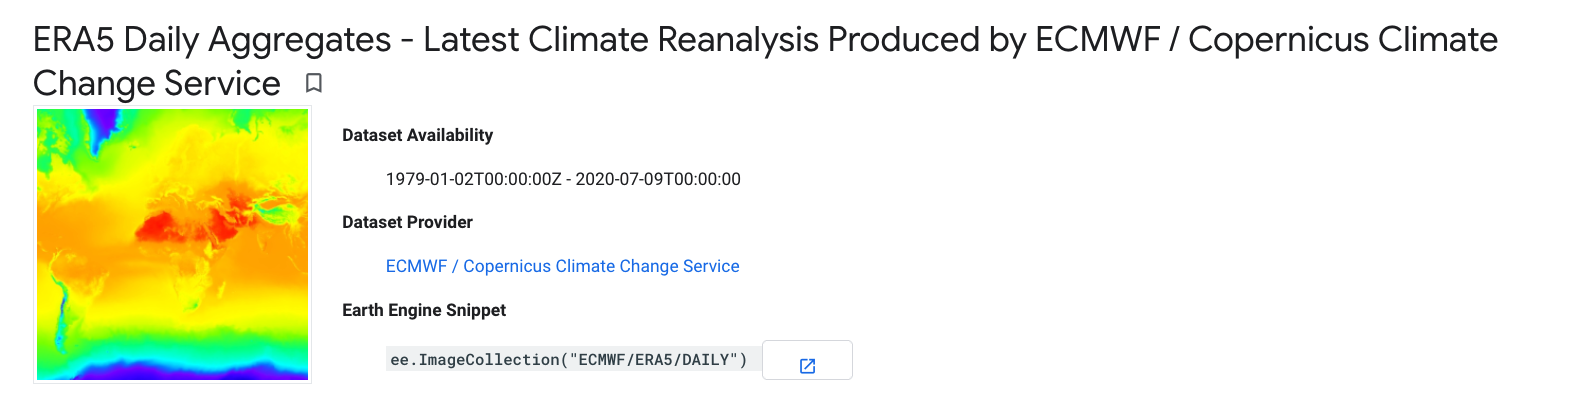

OK we'll come back to the time thing in a minute. First, let's format the data a little bit. The `df` dataframe that gets read in directly from GEE contains the column headers as the first row, rather than as actual header labels. We can change that with the following commands:

In [8]:
headers=df.loc[0]     # Assign the first entry in the data frame to a variable called "headers"
print(headers)        # Look at what's in there

0                     id
1              longitude
2               latitude
3                   time
4    total_precipitation
Name: 0, dtype: object


In [9]:
df = pd.DataFrame(df.values[1:], columns=headers)      # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers
print(df)     # Make sure it worked

0            id  longitude  latitude           time total_precipitation
0      19790102 -119.69602  34.41895   284083200000                   0
1      19790103 -119.69602  34.41895   284169600000             0.00015
2      19790104 -119.69602  34.41895   284256000000            0.000327
3      19790105 -119.69602  34.41895   284342400000            0.019212
4      19790106 -119.69602  34.41895   284428800000            0.007883
...         ...        ...       ...            ...                 ...
15160  20200705 -119.69602  34.41895  1593907200000                   0
15161  20200706 -119.69602  34.41895  1593993600000                -0.0
15162  20200707 -119.69602  34.41895  1594080000000                   0
15163  20200708 -119.69602  34.41895  1594166400000                   0
15164  20200709 -119.69602  34.41895  1594252800000                   0

[15165 rows x 5 columns]


Now that the column names have been appropriately assigned, we can use them to refer to the relevant parts of the data frame. For instance,

`df['time']`

will retrieve the "time" column from the frame.

Let's do that, and then apply a new method to the result: `pd.to_datetime`. This is a function in the pandas package which does exactly what it sounds like: converts a time variable to pandas "datetime" format. You need to tell it what the input time units are, which I've supplied as ms: this makes `pd.to_datetime` assume that time is given in units of ms since the "origin" time, which for Unix machines for some reason is January 1, 1970.

Once you've done this, you can apply the sanity check described above to see if this works for your dataset.

In [10]:
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

Now if we look at the contents of the `df` dataframe, we should get something very much like the previous version, but containing a new column called `datetime` with the formatted date:

In [11]:
df

,id,longitude,latitude,time,total_precipitation,datetime
0,19790102,-119.69602,34.41895,284083200000,0,1979-01-02
1,19790103,-119.69602,34.41895,284169600000,0.00015,1979-01-03
2,19790104,-119.69602,34.41895,284256000000,0.000327,1979-01-04
3,19790105,-119.69602,34.41895,284342400000,0.019212,1979-01-05
4,19790106,-119.69602,34.41895,284428800000,0.007883,1979-01-06
...,...,...,...,...,...,...
15160,20200705,-119.69602,34.41895,1593907200000,0,2020-07-05
15161,20200706,-119.69602,34.41895,1593993600000,-0.0,2020-07-06
15162,20200707,-119.69602,34.41895,1594080000000,0,2020-07-07
15163,20200708,-119.69602,34.41895,1594166400000,0,2020-07-08


If the above does **not** work for your dataset (maybe since the time has a different unit), you can also try this alternate method of date conversion that uses the "id" column. 

Here I'll again use `pd.to_datetime`, this time with the "format" option set: this tells the function the format ofthe input date string (here "year" "month" "day"). 

*note: I also tried this with no format argument and it worked*, Python is pretty smart about interpreting things if your date string is in a fairly standard format. I've just included the format string here so you can see what it looks like. 

Here's another handy website that does a nice job of explaning the various datetime formats:
https://www.dataindependent.com/pandas/pandas-to-datetime/

In [12]:
df['datetime'] = pd.to_datetime(df['id'],format="%Y%m%d")

In [97]:
df

,id,longitude,latitude,time,total_precipitation,datetime
0,19790102,-119.69602,34.41895,284083200000,0,1979-01-02
1,19790103,-119.69602,34.41895,284169600000,0.00015,1979-01-03
2,19790104,-119.69602,34.41895,284256000000,0.000327,1979-01-04
3,19790105,-119.69602,34.41895,284342400000,0.019212,1979-01-05
4,19790106,-119.69602,34.41895,284428800000,0.007883,1979-01-06
...,...,...,...,...,...,...
15160,20200705,-119.69602,34.41895,1593907200000,0,2020-07-05
15161,20200706,-119.69602,34.41895,1593993600000,-0.0,2020-07-06
15162,20200707,-119.69602,34.41895,1594080000000,0,2020-07-07
15163,20200708,-119.69602,34.41895,1594166400000,0,2020-07-08


### 3) Plotting Time Series

Now that we have a time series, let's display it so we can see what it's like. This can be accomplished via the `matplotlib` package, which was loaded in above as `plt`:

(0.0, 0.12)

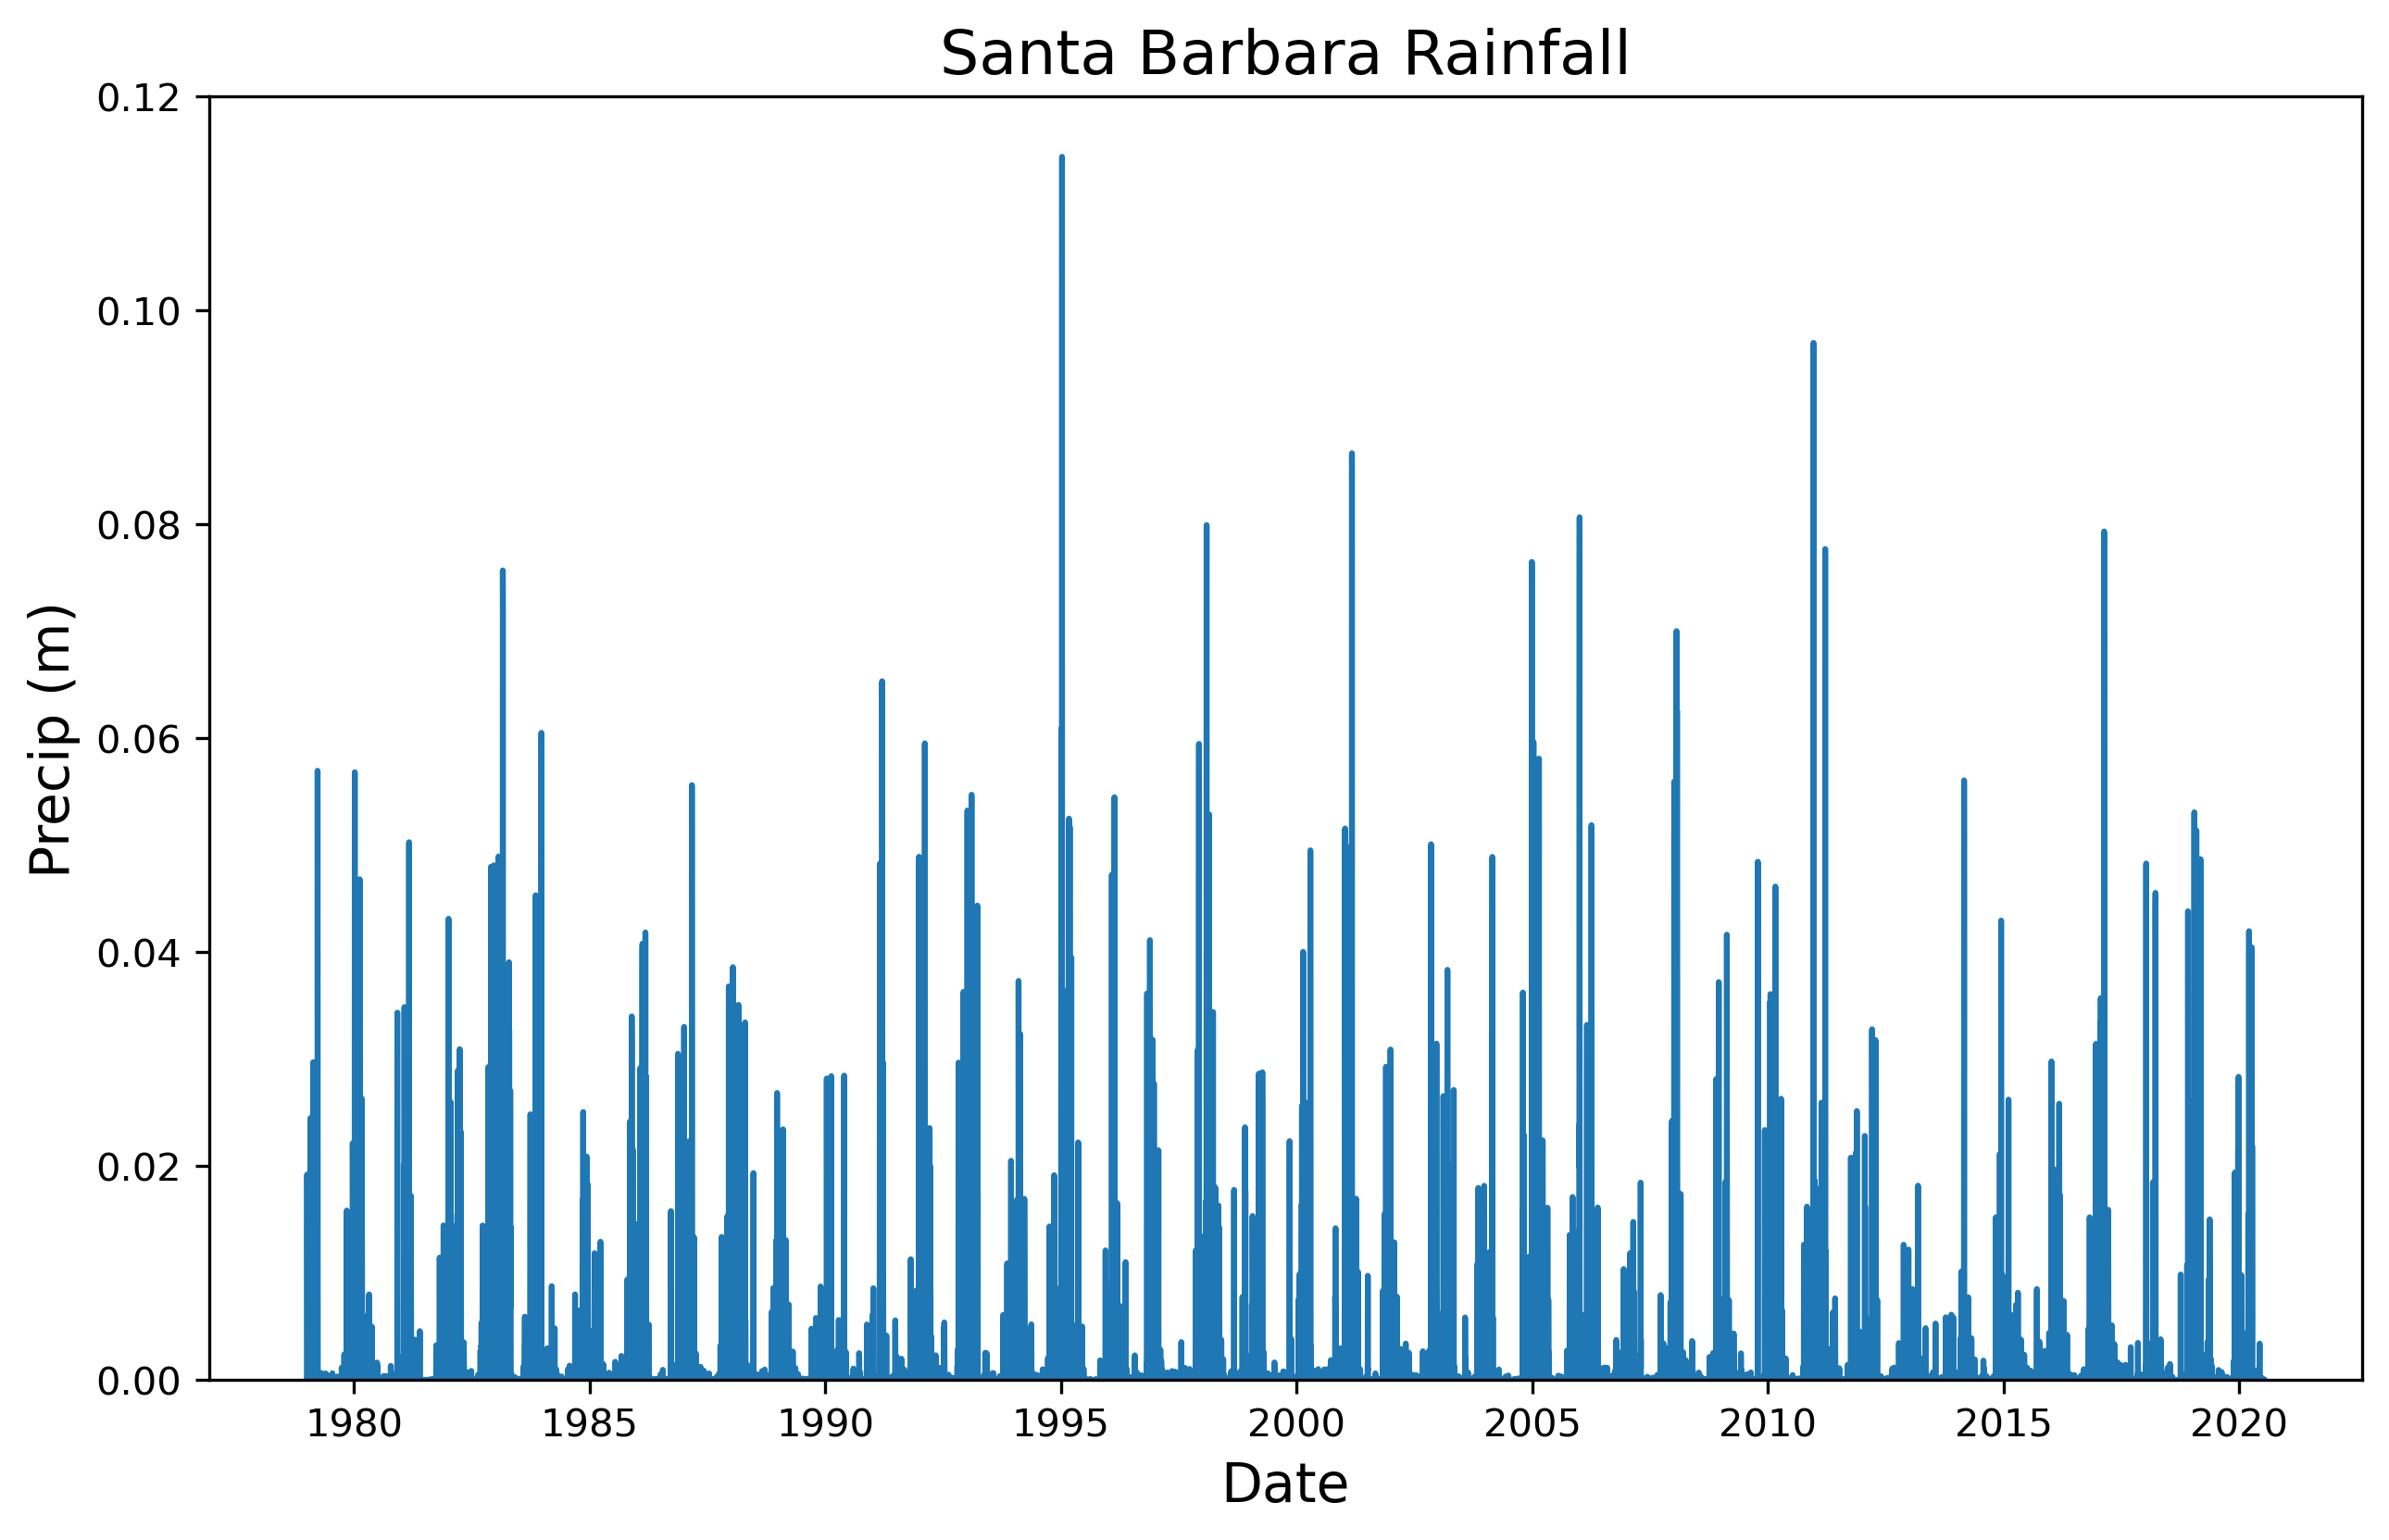

In [13]:
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['total_precipitation'])   # add data to the plot
plt.title('Santa Barbara Rainfall', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precip (m)', fontsize=14)
plt.ylim(0, 0.12)
